# Setup

In [28]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [29]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [1]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [3]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

In [4]:
config = json.load(open("./configs/ext_mnn_em_mscoco.json"))

In [5]:
tmp_path = "/mnt/azmnt/mscoco"

# Loading data

In [6]:
train = pd.read_csv(os.path.join(config["data"]["path"], "train2014.csv"))
train = train.drop({"Unnamed: 0"}, axis=1)
train = train[['description', 'description2', 'path', 'label']]
train

,description,description2,path,label
0,man eats pancaked and drinks while smiling.,man eats pancaked and drinks while smiling.,COCO_train2014_000000539573.jpg,1
1,a woman flying a kite underneath a very blue sky.,a woman catching a frisbee as a man looks onward.,COCO_train2014_000000021459.jpg,0
2,a statue of a man is holding hands with two ch...,a large bed in a room with a fireplace.,COCO_train2014_000000578497.jpg,0
3,dessert on a white plate next to a silver fork.,a meal on a paper plate set on a wood table.,COCO_train2014_000000481039.jpg,0
4,a row of transit buses at a traffic light cros...,a row of transit buses at a traffic light cros...,COCO_train2014_000000252779.jpg,1
...,...,...,...,...
828221,a brown bear stands on a rock while a forest i...,a brown bear stands on a rock while a forest i...,COCO_train2014_000000069350.jpg,1
828222,this kitchen has all white cabinets and a blac...,a man dressed as jesus holding a cell phone,COCO_train2014_000000548559.jpg,0
828223,a woman swinging a baseball bat while standing...,a woman swinging a baseball bat while standing...,COCO_train2014_000000525580.jpg,1
828224,a male is skateboarding on a railing near the ...,"an effigy of a man, strapped to a poll",COCO_train2014_000000237224.jpg,0


In [7]:
val = pd.read_csv(os.path.join(config["data"]["path"], "val2014.csv"))
val = val.drop({"Unnamed: 0"}, axis=1)
val = val[['description', 'description2', 'path', 'label']]
val

,description,description2,path,label
0,a view of several parking lots from an airplane.,a blue and white vase and some blue and white ...,COCO_val2014_000000142940.jpg,0
1,a group of snowboarders in the snowy conditions,a group of snowboarders in the snowy conditions,COCO_val2014_000000004554.jpg,1
2,two kittens steep in a terra cotta pot.,two horses fenced in grazing on the grass.,COCO_val2014_000000568690.jpg,0
3,two tennis players shaking hands on the court,two tennis players shaking hands on the court,COCO_val2014_000000076468.jpg,1
4,"the interstate is void of traffic by the exit,...",a man standing in the forefront of a large clock.,COCO_val2014_000000434148.jpg,0
...,...,...,...,...
405303,two lounges are pictured next to a beautiful p...,a fishing vessel in shallow water at low tide,COCO_val2014_000000004509.jpg,0
405304,a bench has been built next to an old stone bu...,a bench has been built next to an old stone bu...,COCO_val2014_000000330750.jpg,1
405305,a man putting a turkey into the oven.,a man putting a turkey into the oven.,COCO_val2014_000000533452.jpg,1
405306,several elephants dressed for the circus are i...,several elephants dressed for the circus are i...,COCO_val2014_000000292685.jpg,1


In [8]:
img_train = train[["path"]]  # two brackets for keeping the column name
text_train = train["description"]
text2_train = train["description2"]
labels_train = train[["label"]]

In [9]:
img_val = val[["path"]]  # two brackets for keeping the column name
text_val = val["description"]
text2_val = val["description2"]
labels_val = val[["label"]]

# Text processing

## Tokenize texts

In [10]:
tk = CharTokenizer(config["data"]["alphabet"])
text_train = tk.tokenize(text_train)
text_train.shape

(828226, 1014)

In [11]:
text2_train = tk.tokenize(text2_train)
text2_train.shape

(828226, 1014)

In [12]:
text_val = tk.tokenize(text_val)
text_val.shape

(405308, 1014)

In [13]:
text2_val = tk.tokenize(text2_val)
text2_val.shape

(405308, 1014)

## Create embedding weights

In [14]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [15]:
from utils.img_processing import load_img_model, create_embeddings_from

In [16]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

Embeddings for `img_train` take ~80mins on Mobilenetv3small, while `img_val` take ~40mins

In [46]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img_train = create_embeddings_from(img_model,
                                    img_train,
                                    os.path.join(tmp_path,
                                                "train2014"),
                                    batch_size=1024)

Found 828226 validated image filenames.


2023-06-09 21:55:38.751381: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1908232704 exceeds 10% of free system memory.


In [47]:
img_train.shape

(828226, 576)

In [48]:
img_val = create_embeddings_from(img_model,
                                    img_val,
                                    os.path.join(tmp_path,
                                                "val2014"),
                                    batch_size=1024)

Found 405308 validated image filenames.


In [49]:
img_val.shape

(405308, 576)

# Save embeddings

In [17]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [51]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img_train.npy", img_train)
np.save(f"{save_path}/text_train.npy", text_train)
np.save(f"{save_path}/text2_train.npy", text2_train)
train.to_csv(f"{save_path}/train.csv")

In [52]:
np.save(f"{save_path}/img_val.npy", img_val)
np.save(f"{save_path}/text_val.npy", text_val)
np.save(f"{save_path}/text2_val.npy", text2_val)
val.to_csv(f"{save_path}/val.csv")

## Verify import

In [18]:
train = pd.read_csv(f"{save_path}/train.csv")
train = train.drop({"Unnamed: 0"}, axis=1)
train

,description,description2,path,label
0,man eats pancaked and drinks while smiling.,man eats pancaked and drinks while smiling.,COCO_train2014_000000539573.jpg,1
1,a woman flying a kite underneath a very blue sky.,a woman catching a frisbee as a man looks onward.,COCO_train2014_000000021459.jpg,0
2,a statue of a man is holding hands with two ch...,a large bed in a room with a fireplace.,COCO_train2014_000000578497.jpg,0
3,dessert on a white plate next to a silver fork.,a meal on a paper plate set on a wood table.,COCO_train2014_000000481039.jpg,0
4,a row of transit buses at a traffic light cros...,a row of transit buses at a traffic light cros...,COCO_train2014_000000252779.jpg,1
...,...,...,...,...
828221,a brown bear stands on a rock while a forest i...,a brown bear stands on a rock while a forest i...,COCO_train2014_000000069350.jpg,1
828222,this kitchen has all white cabinets and a blac...,a man dressed as jesus holding a cell phone,COCO_train2014_000000548559.jpg,0
828223,a woman swinging a baseball bat while standing...,a woman swinging a baseball bat while standing...,COCO_train2014_000000525580.jpg,1
828224,a male is skateboarding on a railing near the ...,"an effigy of a man, strapped to a poll",COCO_train2014_000000237224.jpg,0


In [19]:
img_train = np.load(f"{save_path}/img_train.npy", allow_pickle=True)
img_train.shape

(828226, 576)

In [20]:
text_train = np.load(f"{save_path}/text_train.npy", allow_pickle=True)
text_train.shape

(828226, 1014)

In [21]:
text2_train = np.load(f"{save_path}/text2_train.npy", allow_pickle=True)
text2_train.shape

(828226, 1014)

In [24]:
val = pd.read_csv(f"{save_path}/val.csv")
val = val.drop({"Unnamed: 0"}, axis=1)
val

,description,description2,path,label
0,a view of several parking lots from an airplane.,a blue and white vase and some blue and white ...,COCO_val2014_000000142940.jpg,0
1,a group of snowboarders in the snowy conditions,a group of snowboarders in the snowy conditions,COCO_val2014_000000004554.jpg,1
2,two kittens steep in a terra cotta pot.,two horses fenced in grazing on the grass.,COCO_val2014_000000568690.jpg,0
3,two tennis players shaking hands on the court,two tennis players shaking hands on the court,COCO_val2014_000000076468.jpg,1
4,"the interstate is void of traffic by the exit,...",a man standing in the forefront of a large clock.,COCO_val2014_000000434148.jpg,0
...,...,...,...,...
405303,two lounges are pictured next to a beautiful p...,a fishing vessel in shallow water at low tide,COCO_val2014_000000004509.jpg,0
405304,a bench has been built next to an old stone bu...,a bench has been built next to an old stone bu...,COCO_val2014_000000330750.jpg,1
405305,a man putting a turkey into the oven.,a man putting a turkey into the oven.,COCO_val2014_000000533452.jpg,1
405306,several elephants dressed for the circus are i...,several elephants dressed for the circus are i...,COCO_val2014_000000292685.jpg,1


In [25]:
img_val = np.load(f"{save_path}/img_val.npy", allow_pickle=True)
img_val.shape

(405308, 576)

In [26]:
text_val = np.load(f"{save_path}/text_val.npy", allow_pickle=True)
text_val.shape

(405308, 1014)

In [27]:
text2_val = np.load(f"{save_path}/text2_val.npy", allow_pickle=True)
text2_val.shape

(405308, 1014)

# Save Char CNN config

In [28]:
from models.char_cnn_zhang import CharCNNZhang

In [29]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [30]:
char_cnn = CharCNNZhang(**char_cnn_config)
char_cnn.model

# Build Extended MNN-EM Model

![](../../assets/images/Extended_MNN_EM.png)

In [31]:
from models.mnn_em import ExtendedMNNEM
from utils.metrics import create_metrics

In [32]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_1_fc_layers"],
    "extended": True,
}

In [33]:
head_2_config = {
    "img_input_size": config["model"]["img_1_fc_layers"][-1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["combined_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_2_fc_layers"],
    "extended": False,
}

In [34]:
ext_mnn_em = ExtendedMNNEM(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    char_cnn=char_cnn.model,
    combined_fc_layers=config["model"]["combined_2_fc_layers"],
    learning_rate=config["model"]["training"]["learning_rate"],
    metrics=create_metrics(config["model"]["training"]["metrics"]))

In [35]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         16127426    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                  

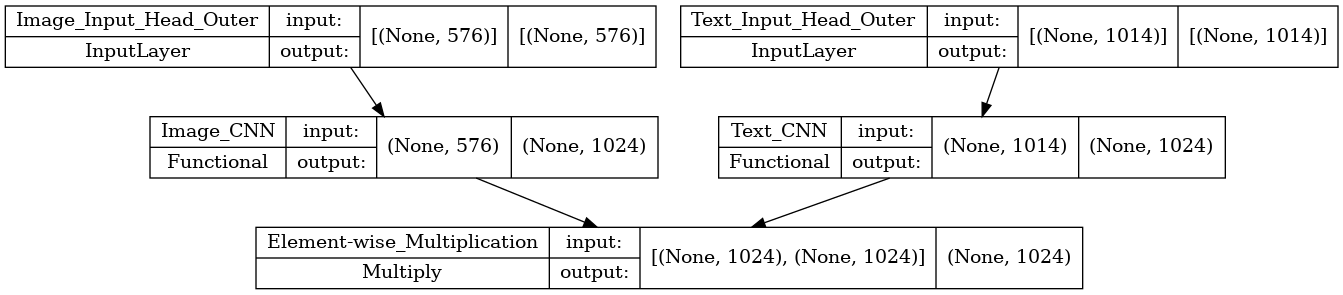

In [36]:
# "Head"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

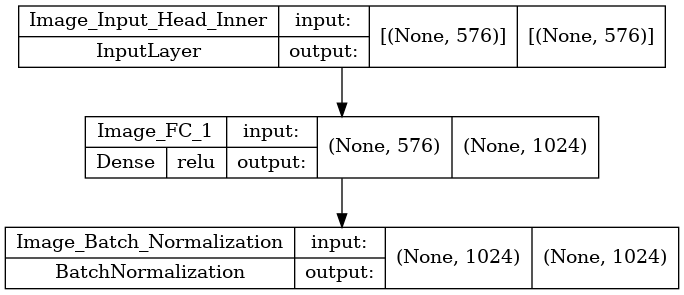

In [37]:
# Image CNN

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

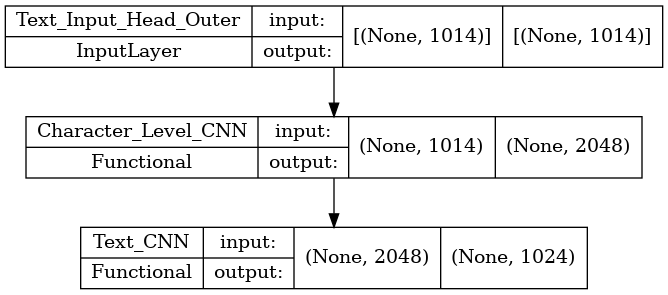

In [38]:
# Text CNN (outer)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

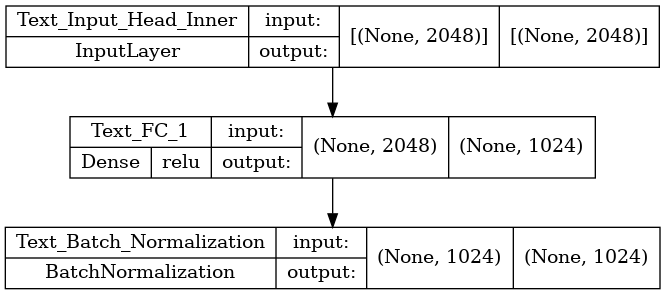

In [39]:
# Text CNN (inner)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3].layers[-1],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

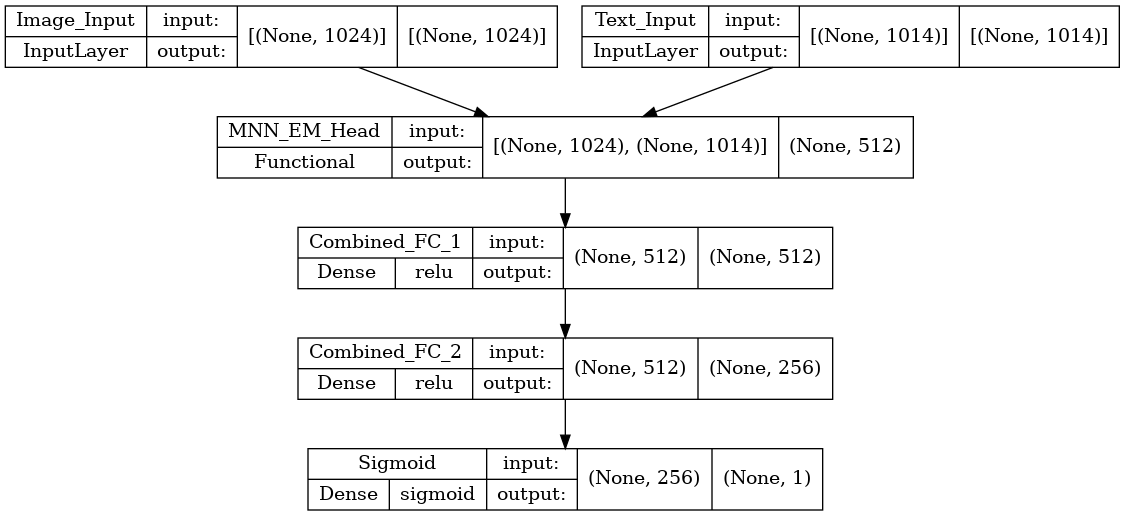

In [40]:
# "Tail"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[4],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

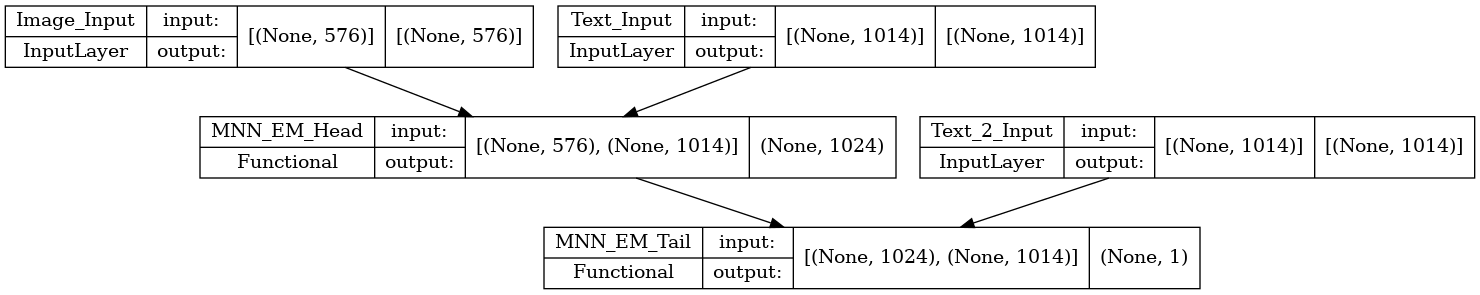

In [41]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model,
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [42]:
from utils.metrics import create_callbacks

In [43]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [44]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [ ]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_data=([img_val, text_val, text2_val], labels_val),
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

2023-06-09 22:39:51.225297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1908232704 exceeds 10% of free system memory.
2023-06-09 22:39:52.537855: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3359284656 exceeds 10% of free system memory.
2023-06-09 22:39:54.865509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3359284656 exceeds 10% of free system memory.
2023-06-09 22:39:57.335854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1908232704 exceeds 10% of free system memory.


Epoch 1/10
6471/6471 [==============================] - ETA: 0s - loss: 4.6485 - recall: 0.7392 - precision: 0.7764 - binary_accuracy: 0.7632 - cosine_similarity: 0.5000

2023-06-09 22:48:43.616941: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 530s 81ms/step - loss: 4.6485 - recall: 0.7392 - precision: 0.7764 - binary_accuracy: 0.7632 - cosine_similarity: 0.5000 - val_loss: 1.0444 - val_recall: 0.9942 - val_precision: 0.8988 - val_binary_accuracy: 0.9411 - val_cosine_similarity: 0.5000
Epoch 2/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.6949 - recall: 0.9873 - precision: 0.9222 - binary_accuracy: 0.9520 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 514s 79ms/step - loss: 0.6949 - recall: 0.9873 - precision: 0.9222 - binary_accuracy: 0.9520 - cosine_similarity: 0.5000 - val_loss: 0.4843 - val_recall: 0.9989 - val_precision: 0.9340 - val_binary_accuracy: 0.9642 - val_cosine_similarity: 0.5000
Epoch 3/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.4027 - recall: 0.9909 - precision: 0.9414 - binary_accuracy: 0.9646 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 510s 79ms/step - loss: 0.4027 - recall: 0.9909 - precision: 0.9414 - binary_accuracy: 0.9646 - cosine_similarity: 0.5000 - val_loss: 0.3160 - val_recall: 0.9994 - val_precision: 0.9458 - val_binary_accuracy: 0.9711 - val_cosine_similarity: 0.5000
Epoch 4/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.2749 - recall: 0.9930 - precision: 0.9520 - binary_accuracy: 0.9715 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 509s 79ms/step - loss: 0.2749 - recall: 0.9930 - precision: 0.9520 - binary_accuracy: 0.9715 - cosine_similarity: 0.5000 - val_loss: 0.2282 - val_recall: 0.9996 - val_precision: 0.9519 - val_binary_accuracy: 0.9746 - val_cosine_similarity: 0.5000
Epoch 5/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.2012 - recall: 0.9944 - precision: 0.9599 - binary_accuracy: 0.9764 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 509s 79ms/step - loss: 0.2012 - recall: 0.9944 - precision: 0.9599 - binary_accuracy: 0.9764 - cosine_similarity: 0.5000 - val_loss: 0.1770 - val_recall: 0.9998 - val_precision: 0.9569 - val_binary_accuracy: 0.9774 - val_cosine_similarity: 0.5000
Epoch 6/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.1539 - recall: 0.9951 - precision: 0.9660 - binary_accuracy: 0.9800 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 509s 79ms/step - loss: 0.1539 - recall: 0.9951 - precision: 0.9660 - binary_accuracy: 0.9800 - cosine_similarity: 0.5000 - val_loss: 0.1441 - val_recall: 0.9997 - val_precision: 0.9608 - val_binary_accuracy: 0.9795 - val_cosine_similarity: 0.5000
Epoch 7/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.1215 - recall: 0.9959 - precision: 0.9712 - binary_accuracy: 0.9832 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 513s 79ms/step - loss: 0.1215 - recall: 0.9959 - precision: 0.9712 - binary_accuracy: 0.9832 - cosine_similarity: 0.5000 - val_loss: 0.1229 - val_recall: 0.9997 - val_precision: 0.9651 - val_binary_accuracy: 0.9818 - val_cosine_similarity: 0.5000
Epoch 8/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.0982 - recall: 0.9962 - precision: 0.9754 - binary_accuracy: 0.9855 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 509s 79ms/step - loss: 0.0982 - recall: 0.9962 - precision: 0.9754 - binary_accuracy: 0.9855 - cosine_similarity: 0.5000 - val_loss: 0.1079 - val_recall: 0.9993 - val_precision: 0.9660 - val_binary_accuracy: 0.9820 - val_cosine_similarity: 0.5000
Epoch 9/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.0808 - recall: 0.9967 - precision: 0.9790 - binary_accuracy: 0.9877 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 509s 79ms/step - loss: 0.0808 - recall: 0.9967 - precision: 0.9790 - binary_accuracy: 0.9877 - cosine_similarity: 0.5000 - val_loss: 0.0965 - val_recall: 0.9993 - val_precision: 0.9688 - val_binary_accuracy: 0.9836 - val_cosine_similarity: 0.5000
Epoch 10/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.0686 - recall: 0.9969 - precision: 0.9817 - binary_accuracy: 0.9891 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 510s 79ms/step - loss: 0.0686 - recall: 0.9969 - precision: 0.9817 - binary_accuracy: 0.9891 - cosine_similarity: 0.5000 - val_loss: 0.0916 - val_recall: 0.9994 - val_precision: 0.9693 - val_binary_accuracy: 0.9839 - val_cosine_similarity: 0.5000


# Evaluation

## Plot loss and metrics

In [ ]:
from utils.metrics import plot_metrics

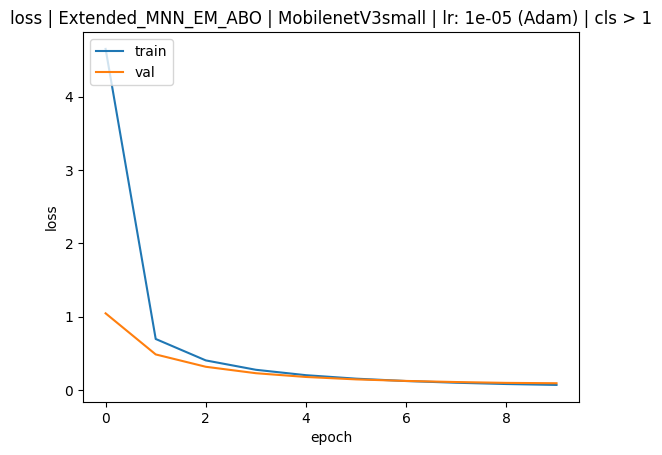

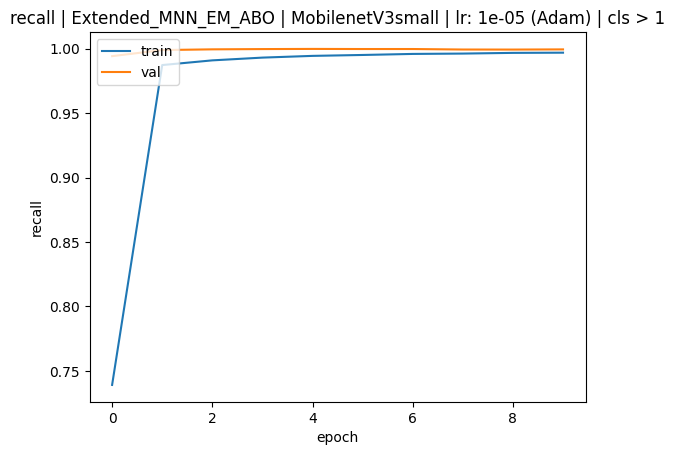

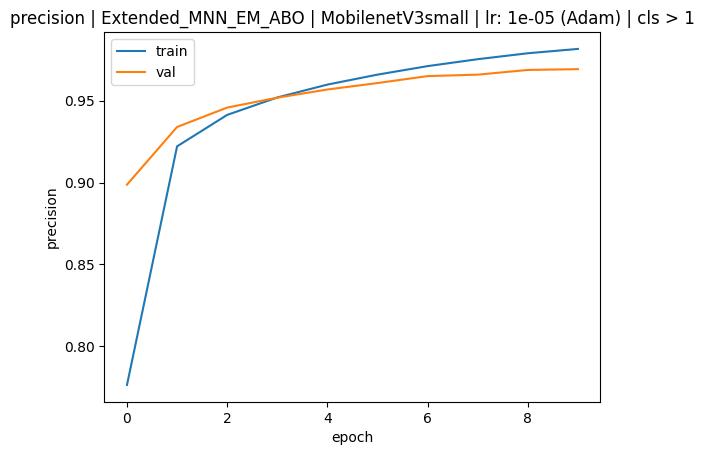

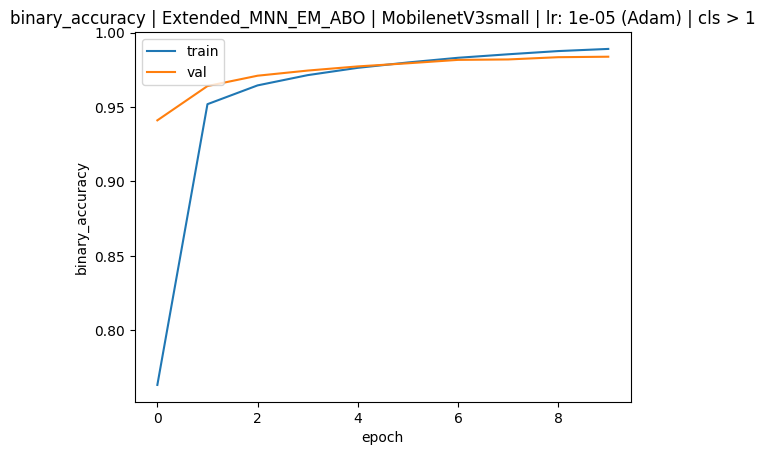

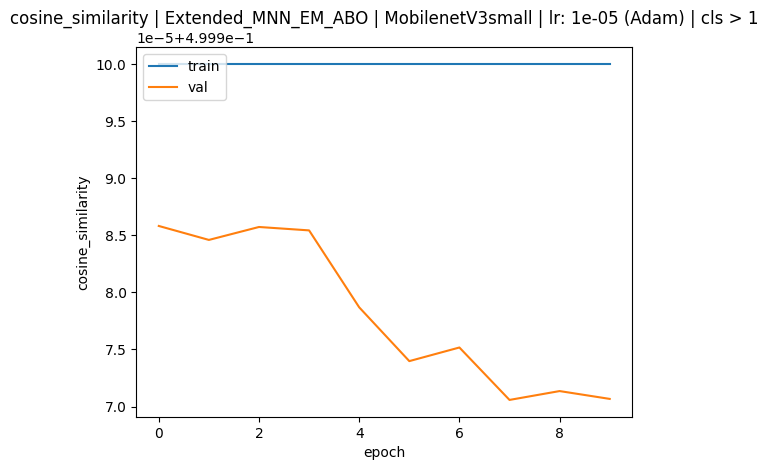

In [ ]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [46]:
from utils.metrics import evaluate

Since there are no annotations included in `test2014`, we use `val2014` for evaluation instead

In [47]:
evaluate(ext_mnn_em.model, [img_val, text_val, text2_val], labels_val,
         log_dir, model_name, img_model.name, optimizer_name, learning_rate,
         config["data"]["cls"])

405308/405308 [==============================] - 2327s 6ms/step - loss: 0.0917 - recall: 0.9994 - precision: 0.9693 - binary_accuracy: 0.9839 - cosine_similarity: 0.5000
